# Analyzing the success of Kickstarter Campaigns
###### By: Kay Delventhal, Christoph Michel & Christian Steck

In the following notebook, we will analyze the success and failure of Kickstarter-Campaigns. Our stakeholder is a social-media agency that specializes in crowd-funding campaigns. They look for promising ideas and manage the campaings. If the campaing is successful, our stakeholder gets a percentage of the pledged money. If the campaign fails, the don't get any compensation. Our goal is to make recommendations, which type of campaign will be profitable and develop a model, that predicts whether a campaign will be successful.

## 1. The data

We have managed to get a dataset of kickstarter campaigns that was scraped by webrobots.io. The dataset has information on 209.222 campaigns.

In [1]:
import glob
import os
import string
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('data', '*.csv'))))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 3791
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obj

### 1.1. Data cleaning

We can see, that the ID-column has less unique entries than non-null values. This means, there are duplicates in the ID. Let's check, whether they are actual duplicates.

In [4]:
#check duplicates if state is 'failed' or 'successfull'

df[(df.duplicated(subset='id', keep=False)) & ((df.state=='failed')| (df.state=='successful'))].sort_values('id').iloc[0:5, 1:]

,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
2090,"The BEST beef sticks, beef jerky and signature...","{""id"":313,""name"":""Small Batch"",""slug"":""food/sm...",3239,US,1463338701,"{""id"":1455229821,""name"":""Mark Bechard"",""is_reg...",USD,$,True,USD,...,the-meat-candy-experience,https://www.kickstarter.com/discover/categorie...,True,False,successful,1467326058,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3239.000000,international
1811,"The BEST beef sticks, beef jerky and signature...","{""id"":313,""name"":""Small Batch"",""slug"":""food/sm...",3239,US,1463338701,"{""id"":1455229821,""name"":""Mark Bechard"",""is_reg...",USD,$,True,USD,...,the-meat-candy-experience,https://www.kickstarter.com/discover/categorie...,True,False,successful,1467326058,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3239.000000,domestic
2342,"4tec is a classic 4 in a row table top game, r...","{""id"":34,""name"":""Tabletop Games"",""slug"":""games...",15368,IE,1530787618,"{""id"":939296767,""name"":""John Dunne"",""is_regist...",EUR,€,False,USD,...,4tec-a-new-3d-connect-4-game,https://www.kickstarter.com/discover/categorie...,True,False,successful,1539154131,1.156384,"{""web"":{""project"":""https://www.kickstarter.com...",15440.032893,international
3224,"4tec is a classic 4 in a row table top game, r...","{""id"":34,""name"":""Tabletop Games"",""slug"":""games...",15368,IE,1530787618,"{""id"":939296767,""name"":""John Dunne"",""is_regist...",EUR,€,False,USD,...,4tec-a-new-3d-connect-4-game,https://www.kickstarter.com/discover/categorie...,True,False,successful,1539154131,1.156384,"{""web"":{""project"":""https://www.kickstarter.com...",15440.032893,domestic
1363,Professional graphic designers need profession...,"{""id"":27,""name"":""Graphic Design"",""slug"":""desig...",2985,US,1522956916,"{""id"":1070452795,""name"":""Mike Wofsey"",""slug"":""...",USD,$,True,USD,...,graphic-design-tools-for-your-most-beautiful-work,https://www.kickstarter.com/discover/categorie...,True,False,successful,1527877351,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2985.000000,domestic


The duplicate ids seem to be actual duplicates. Drop them (drop last)

In [5]:
df=df.drop_duplicates(subset='id')
df.shape

(182264, 37)

After dropping the duplicate rows, we are left with 182.264 campaigns.

The next variable, we are looking at, is `state`, our target variable. 

In [6]:
df.state.unique()

array(['live', 'successful', 'failed', 'canceled', 'suspended'],
      dtype=object)

State has the categories *live*, *successful*, *failed*, *canceled* and *supended*. We are only interested in successful and failed campaigns. Thus we change `state` 'successful' and 'failed' to 1 and 0 and drop the rest.

In [7]:
df = df[(df["state"] == "successful") | (df["state"] == "failed")]
booleans = {'successful': 1, 'failed': 0}
df['state'] = df['state'].map(booleans)

Another interesting factor for our analysis is, how big the funding goal of the campaing was. We know that campaigns can use different currencies. We look, whether `goal`is standardized USD, or has different currencies in it.

In [8]:
df[(df.state==1)&(df.currency!="USD")].loc[:,['goal','pledged','usd_pledged', 'static_usd_rate']]

,goal,pledged,usd_pledged,static_usd_rate
8,375.0,375.0,529.786729,1.412765
9,380.0,1954.0,2516.160602,1.287697
16,4200.0,4230.0,4701.023782,1.111353
17,15000.0,20169.0,15328.270782,0.759992
22,1000.0,1015.0,702.613237,0.692230
...,...,...,...,...
3738,3000.0,4295.0,6275.184753,1.461044
3751,6000.0,7084.0,8060.625388,1.137864
3774,6200.0,6805.0,4854.666789,0.713397
3779,2000.0,2001.0,2269.685356,1.134276


We can conclude that `goal` is not necessarily in USD. We see in idx 22, that the amount of `usd_pledged`is lower than `goal`, but the campaing was still successfull.
We get the comparable amounts of `goal` in USD if we multiply it by `static_usd_rate`.

In [9]:
df['usd_goal'] = df.goal*df.static_usd_rate
df[(df.state==1)&(df.currency!="USD")].loc[:,['goal','pledged','usd_pledged', 'static_usd_rate', 'usd_goal']]

,goal,pledged,usd_pledged,static_usd_rate,usd_goal
8,375.0,375.0,529.786729,1.412765,529.786729
9,380.0,1954.0,2516.160602,1.287697,489.324989
16,4200.0,4230.0,4701.023782,1.111353,4667.683188
17,15000.0,20169.0,15328.270782,0.759992,11399.874150
22,1000.0,1015.0,702.613237,0.692230,692.229790
...,...,...,...,...,...
3738,3000.0,4295.0,6275.184753,1.461044,4383.132540
3751,6000.0,7084.0,8060.625388,1.137864,6827.181300
3774,6200.0,6805.0,4854.666789,0.713397,4423.061586
3779,2000.0,2001.0,2269.685356,1.134276,2268.551080


Campaign success is not binary. There might be campaigns that just missed their goal and needed a little push and there are campaigns that reach more funding than their goal. To check for that, we create a new feature `pledge_to_goal` that contains the ratio of pledged money to the goal.

In [10]:
df["pledge_to_goal"] = df["usd_pledged"] / df["usd_goal"]

Campaigns can have different durations and these might influence the successrate. We can calculate the duration in seconds by substracting `launched_at` from`deadline`.

In [11]:
#time setting for duration (of project? until cut-off)
df["launch_to_deadline"] = df["deadline"] - df["launched_at"]

Users can give their campaigns names, a description and key-words. The length of these features might influence success. Maybe more information leeds to more success, maybe TL;DR. So we count the number words of the project description and the name of project and number of tags.

In [12]:
df['blurb_wc'] = df.blurb.str.replace(r' [{}]'.format(string.punctuation), '').str.split().str.len() # get rid of standalone punctuation, to avoid '-' beeing counted as a word
df['name_wc'] = df.name.str.replace(r' [{}]'.format(string.punctuation), '').str.split().str.len() # get rid of standalone punctuation, to avoid '-' beeing counted as a word
df['slug_wc']= df.slug.str.split('-').str.len()

We also have a column `category` that contains dictionaries. From that column we can get the main- and sub-categories of the campaigns. 

In [13]:
df['categories'] = df['category'].map(eval).apply(lambda x: x['slug'].split('/'))
df['cat_name'] = df['category'].map(eval).apply(lambda x: x['name']) 
df['cat_main'] = df['categories'].apply(lambda x: x[0])
df['cat_sub'] = df['categories'].apply(lambda x: x[1] if len(x)==2  else '0')


### 1.2. EDA
#### 1.2.1. Target

Our target variable is the success of the campaigns. So let's see, how many are succesful and how successful they are. 

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_palette('muted')

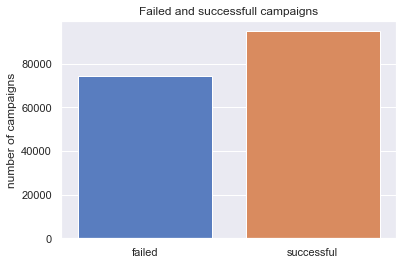

From all 168979 campaigns in the dataset, 56.09% are succesful.


In [15]:
ax = sns.countplot(x='state', data=df)
ax.set(xlabel='', ylabel='number of campaigns', title='Failed and successfull campaigns')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.show()
print(f'From all {df.shape[0]} campaigns in the dataset, {round(df.state.mean()*100, 2)}% are succesful.')

Lucky for us, more than half of the campaigns are successful. But how many are nearly successful and how successful are the successful campaigns?

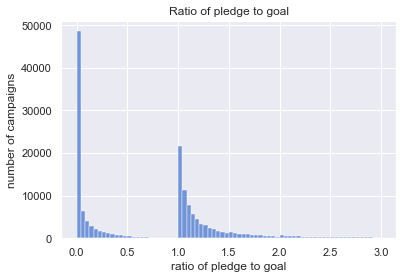

Median proportion of goal reached for successful campaign: 117.43%
Proportion of successful campaigns that reach more than double of their goal: 19.74%
Median proportion of goal reached for failed campaign: 1.0%
Proportion of failed campaigns that had at least 50% funding: 3.22%


In [16]:
ax=sns.histplot(x=df[df['pledge_to_goal']<3].pledge_to_goal)
ax.set(xlabel='ratio of pledge to goal', ylabel='number of campaigns', title='Ratio of pledge to goal')
plt.show()
print('Median proportion of goal reached for successful campaign: ' + str(round(df[df['pledge_to_goal']>=1].pledge_to_goal.median()*100, 2))+'%')
print('Proportion of successful campaigns that reach more than double of their goal: ' + str(round(df[(df['state']==1) & (df['pledge_to_goal']>=2)].shape[0]/df[(df['state']==1)].shape[0]*100,2))+'%')
print('Median proportion of goal reached for failed campaign: ' + str(round(df[df['pledge_to_goal']<1].pledge_to_goal.median()*100, 2))+'%')
print('Proportion of failed campaigns that had at least 50% funding: ' + str(round(df[(df['state']==0) & (df['pledge_to_goal']>=0.5)].shape[0]/df[(df['state']==0)].shape[0]*100,2))+'%')

We can see, that most campaigns either reach their goals or reach almost nothing. There are hardly any campaigns, that almost get their funding.
We can also see that successful campaigns can reach more than their goal. Almost 20% of campaigns more than double their goal.

#### 1.2.1. Categories

Kickstarter let's their users categorize their campaings in one of 15 main categories. Let's have a look at them.

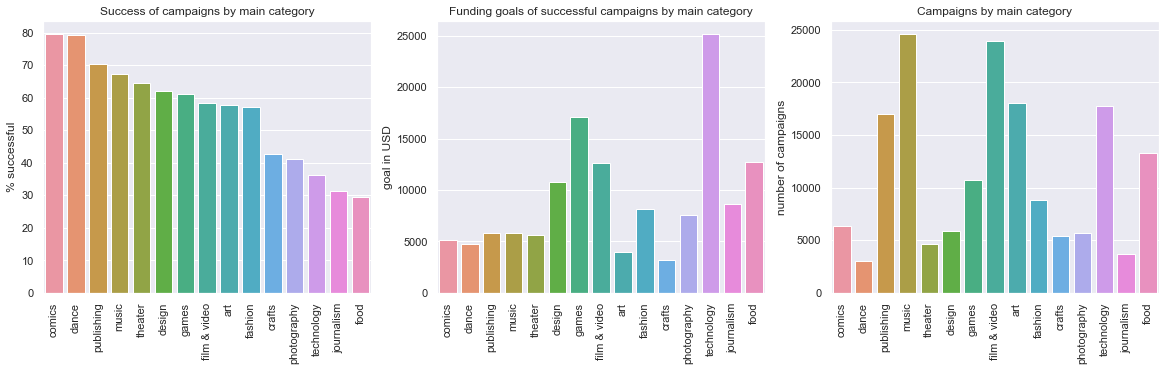

In [17]:
cat_grou = df.groupby('cat_main')
order2 = [key for key in cat_grou.state.mean().sort_values(ascending=False).to_dict()]
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x=df.cat_main, y=df.state*100, order=order2, ci = None)
ax.set(xlabel='', ylabel='% successful', title='Success of campaigns by main category')
plt.xticks(rotation=90)
plt.subplot(1, 3, 2)
ax = sns.barplot(x='cat_main', y='usd_goal', data=df[df['state']==1], order=order2, ci = None)
ax.set(xlabel='', ylabel='goal in USD', title='Funding goals of successful campaigns by main category')
plt.xticks(rotation=90)
plt.subplot(1, 3, 3)
ax = sns.countplot(x=df.cat_main, order=order2)
ax.set(xlabel='', ylabel='number of campaigns', title='Campaigns by main category')
plt.xticks(rotation=90)
plt.show()

We can see that comics, dance and publishing have very high success-rates (>70%), while the success rates for technology, journalism and food are very low (<40%). On the other hand, the mean funding goals for comics, dance and publishing are low (~ USD 5.000). The funding goal for technology on the other hand is very high (~ USD 25.000). Games seem to be in the sweet spot with both reasonably high success rates (~ 60%) and high funding goals (~ USD 17.000).

This means, we could diversify our campaigns with low risk options, high revenue options and the solid candidate games.

Let's have a closer look into the subcategories of games!

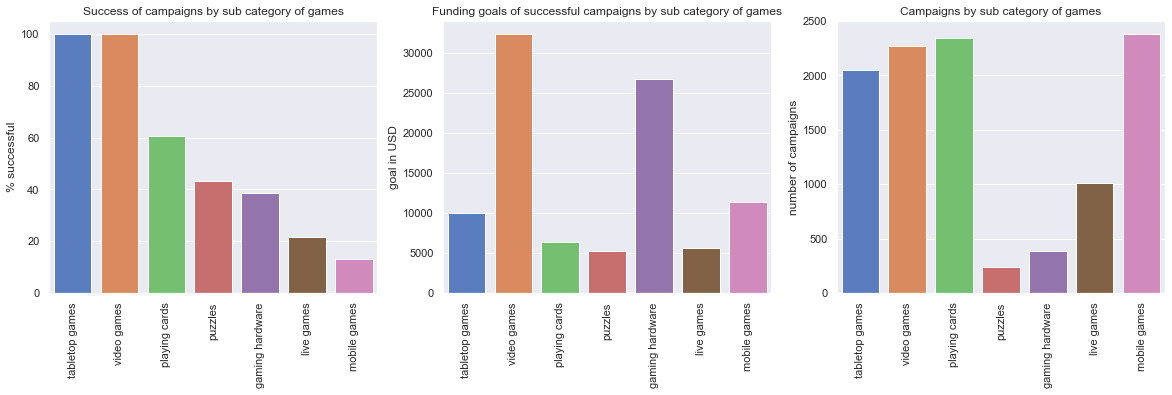

In [18]:
df2 = df[(df['cat_main']=='games') & (df['cat_sub']!='0')]
cat_grou = df2.groupby('cat_sub')
order2 = [key for key in cat_grou.state.mean().sort_values(ascending=False).to_dict()]
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x=df2.cat_sub, y=df2.state*100, order=order2, ci = None)
ax.set(xlabel='', ylabel='% successful', title='Success of campaigns by sub category of games')
plt.xticks(rotation=90)
plt.subplot(1, 3, 2)
ax = sns.barplot(x='cat_sub', y='usd_goal', data=df2[df2['state']==1], order=order2, ci = None)
ax.set(xlabel='', ylabel='goal in USD', title='Funding goals of successful campaigns by sub category of games')
plt.xticks(rotation=90)
plt.subplot(1, 3, 3)
ax = sns.countplot(x=df2.cat_sub, order=order2)
ax.set(xlabel='', ylabel='number of campaigns', title='Campaigns by sub category of games')
plt.xticks(rotation=90)
plt.show()

Tabletop games and video games have perfect success rates! They also have a lot of campaigns. The revenue for tabletop games is in the medium range. The revenue for video games is super high! So invest in video games. And everybody knows that mobile gaming isn't real gaming, so stay away from that!

#### 1.2.2. Countries

We have information on the countries, where the campaigns originate. Let's have a look at them

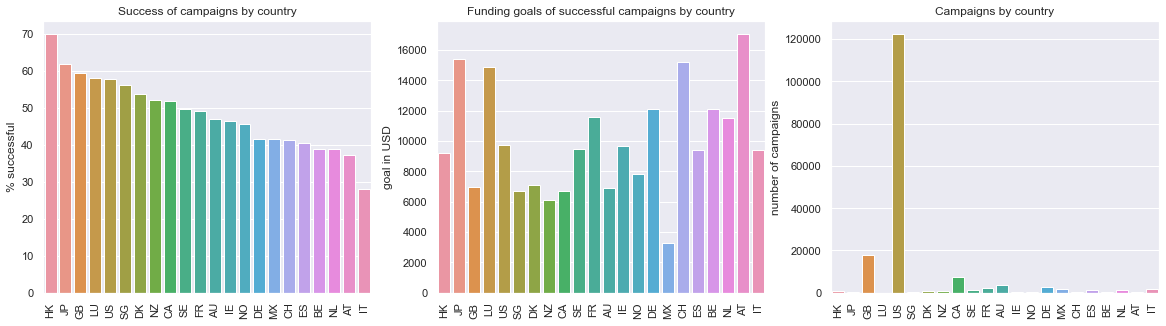

In [19]:
cat_grou = df.groupby('country')
order2 = [key for key in cat_grou.state.mean().sort_values(ascending=False).to_dict()]
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x=df.country, y=df.state*100, order=order2, ci = None)
ax.set(xlabel='', ylabel='% successful', title='Success of campaigns by country')
plt.xticks(rotation=90)
plt.subplot(1, 3, 2)
ax = sns.barplot(x='country', y='usd_goal', data=df[df['state']==1], order=order2, ci = None)
ax.set(xlabel='', ylabel='goal in USD', title='Funding goals of successful campaigns by country')
plt.xticks(rotation=90)
plt.subplot(1, 3, 3)
ax = sns.countplot(x=df.country, order=order2)
ax.set(xlabel='', ylabel='number of campaigns', title='Campaigns by country')
plt.xticks(rotation=90)
plt.show()

The countries with the highest success rates are Hong Kong, Japan, Great Britain, Luxemburg, the US and Singapore. The high risk countries are Switzerland, Spain, Belgium, the Netherlands, Austria and Italy. The low risk countries all ovver medium to high goals. If we look at the number of campaigns by country, we see that the US dominates the market, followed (with a huge margin) by Great Britain and Canada. 

This graphs show us, that we should focus and the US Market and the english speaking countries. If we can get an access, we could branch out in the Asian market. Mainland Europe is not interesting for us.

#### 1.2.3. Staff pick

Some campaigns get picked by the staff of kickstarter and get featured on the explore page. This might be good a good advertisment for the campaign. Lets see, how they perform.

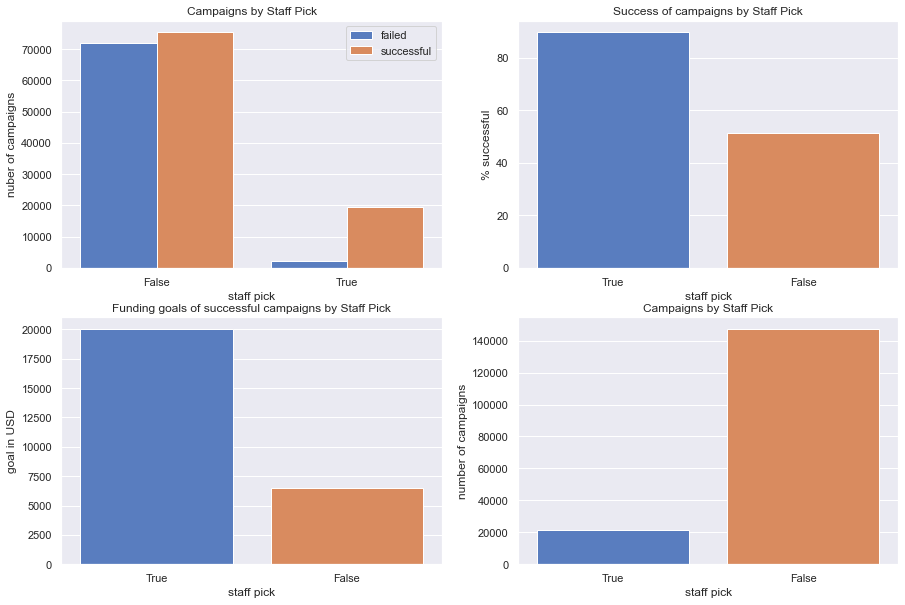

In [20]:
cat_grou = df.groupby('staff_pick')
order2 = [key for key in cat_grou.state.mean().sort_values(ascending=False).to_dict()]
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
ax = sns.countplot(hue=df.state, x=df.staff_pick)
ax.set(xlabel='staff pick', ylabel='nuber of campaigns', title='Campaigns by Staff Pick')
plt.gca().legend(('failed', 'successful'))
plt.subplot(2, 2, 2)
ax = sns.barplot(x=df.staff_pick, y=df.state*100, order=order2, ci = None)
ax.set(xlabel='staff pick', ylabel='% successful', title='Success of campaigns by Staff Pick')
plt.subplot(2, 2, 3)
ax = sns.barplot(x='staff_pick', y='usd_goal', data=df[df['state']==1], order=order2, ci = None)
ax.set(xlabel='staff pick', ylabel='goal in USD', title='Funding goals of successful campaigns by Staff Pick')
plt.subplot(2, 2, 4)
ax = sns.countplot(x=df.staff_pick, order=order2)
ax.set(xlabel='staff pick', ylabel='number of campaigns', title='Campaigns by Staff Pick')
plt.show()

The success-rate of staff picked is very high (>80%) and the funding goal of successful campaigns as well. For non-picked campaigns both values are much lower. On the other hand, only a small proportion of campaigns get picked by the staff. While we don't know, if getting staff picked leeds to successful campaigns, or if the staff picks campaigns, that are promising to be successful, getting staff picked seems to be beneficial. There seem to be ways to push a campaing to be [staff picked](https://www.crowdcrux.com/become-kickstarter-staff-pick/).

#### 1.2.4. Word counts

Another metric we are interested in, is whether the length of the title, description or the number of tags used has any influence on the success-rate.

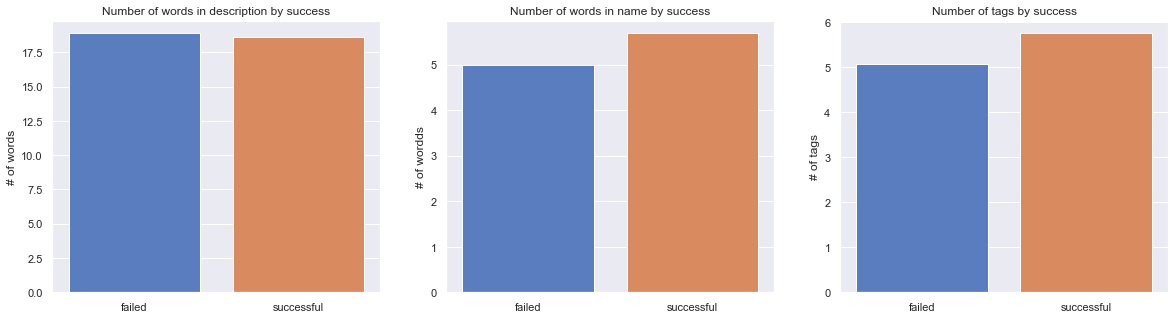

In [21]:
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x=df.state, y=df.blurb_wc, ci = None)
ax.set(xlabel='', ylabel='# of words', title='Number of words in description by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.subplot(1, 3, 2)
ax = sns.barplot(x=df.state, y=df.name_wc, ci = None)
ax.set(xlabel='', ylabel='# of wordds', title='Number of words in name by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.subplot(1, 3, 3)
ax = sns.barplot(x=df.state, y=df.slug_wc, ci = None)
ax.set(xlabel='', ylabel='# of tags', title='Number of tags by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.show()


For the description there is no substantial difference in the mean number of words for successful and failed campaigns. But the titles of successful campaigns seem to be slightly longer and the number of tags is higher. So more information seems to be better for success.

#### 1.2.5. Duration

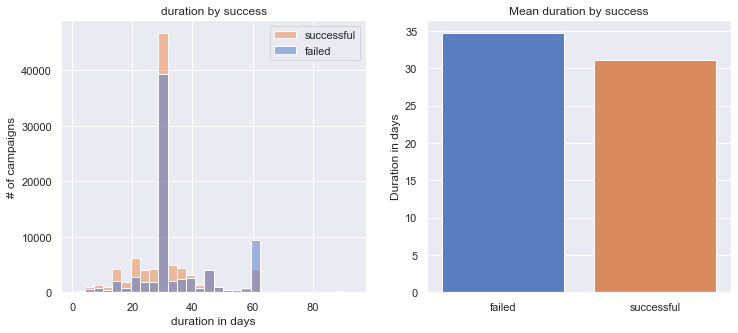

In [22]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
ax = sns.histplot(x=df.launch_to_deadline.apply(lambda x: x/(3600*24)), hue=df.state, bins=30)
ax.set(xlabel='duration in days', ylabel = '# of campaigns',title='duration by success')
plt.gca().legend(('successful', 'failed'))
plt.subplot(1, 2, 2)
ax = sns.barplot(x=df.state, y=df.launch_to_deadline.apply(lambda x: x/(3600*24)) , ci = None)
ax.set(xlabel='', ylabel='Duration in days', title='Mean duration by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.show()

We see, that the majority of campaigns are set to be 30 days long. A second, smaller peek is at 60 days. Below 40 days the number of successful campaings is higher. Over 40 days, it's equal. At 60 days there are more failed than successful campaings. This is reflected in the mean duration of the campaigns. So shorter campaigns seem to be more succesfull.

#### 1.2.6. Goals

The last step in our analysis is, to see, whether campaigns with a higher goal are more successful than campaigns with lower goals.

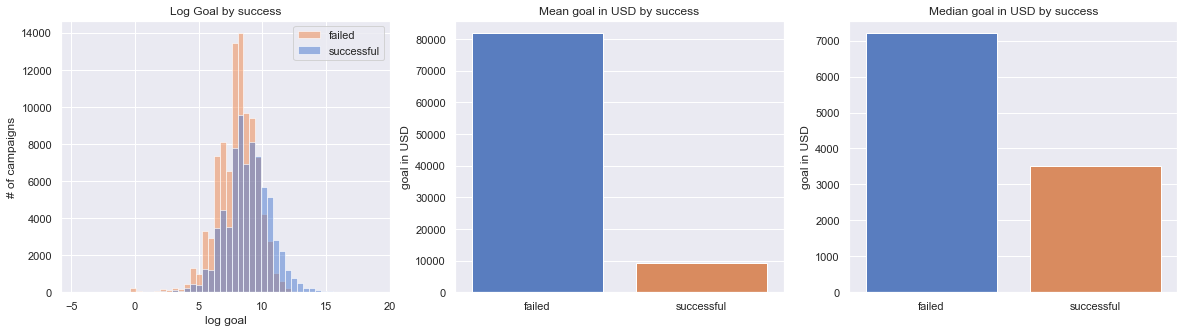

In [23]:
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
ax = sns.histplot(x=np.log(df.usd_goal), hue=df.state, bins=50)
ax.set(ylabel='# of campaigns', xlabel='log goal', title='Log Goal by success')
plt.gca().legend(('failed', 'successful'))
plt.subplot(1, 3, 2)
ax = sns.barplot(x=df.state, y=df.usd_goal, ci = None)
ax.set(xlabel='', ylabel='goal in USD', title='Mean goal in USD by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.subplot(1, 3, 3)
ax = sns.barplot(x=df.state, y=df.usd_goal, estimator=np.median,  ci = None)
ax.set(xlabel='', ylabel='goal in USD', title='Median goal in USD by success')
plt.xticks(ticks=[0,1], labels=['failed','successful'])
plt.show()

From the graphs it is obvious, that campaigns with a higher goal have a lower success-rate. So we have a trade-off between risk and profit-margin.

## 2. General modelling

We are building a modell to predict the success of kickstarter campaigns with the given features that are available before the launch of a project.

### 2.1. Importing the right modules

#### Import Basic Python Modules

In [24]:
import numpy as np
import pandas as pd
import pickle
from time import time
from datetime import datetime
import seaborn as sns

#### Import SciKit-Learn Modules

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, \
                            precision_score, f1_score, fbeta_score, make_scorer, classification_report

#### Import Classifier and Regressions

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# pip install xgboost
from xgboost import XGBClassifier

In [27]:
# logging helper
def log_print(*args):
    if not len(args):
        text = '='*80
    else:
        text = args[0]
    LOGGING.append(''.join([text,'\n']))
    print(text) 

### 2.2. Data Splitting

We split the data in train and test splits and prepare the columns for the pipeline.

In [28]:
work = df
RSEED = 42
CHUNCK = 0.33
TSIZE = 0.3


cats = ['cat_main', 'cat_sub']


nums = ['name_wc', 'slug_wc', 'launch_to_deadline', 'usd_goal'] 

targ = ['state']

if CHUNCK != 1:
    _, temp = train_test_split(work, test_size=CHUNCK, random_state=RSEED)
else:
    temp = data.copy()
print('data shape   :', work.shape)
print('temp shape   :', temp.shape)

features = temp[cats+nums]
tragets = temp[targ]

X_train, X_test, y_train, y_test = train_test_split(features, tragets, test_size = TSIZE, random_state = RSEED)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train_num = X_train[nums]
X_train_cat = X_train[cats]
X_test_num = X_test[nums]
X_test_cat = X_test[cats]

data shape   : (168979, 47)
temp shape   : (55764, 47)
X_train shape: (39034, 6)
y_train shape: (39034, 1)
X_test shape : (16730, 6)
y_test shape : (16730, 1)


### 2.3. Pipeline Setup

We set the pipeline for our model. We impute missing values, standardize numerical features and dummy encode categorical features.

In [29]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, nums),
    ('cat', cat_pipeline, cats)
])

In [31]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_model = Pipeline([('prep', preprocessor),
                        ('model', LogisticRegression(max_iter=1000,random_state=RSEED))])

#### 2.4. Model building

we build a logistic regression model to predict the success of kickstarter campaign. We use Precision as the metric to evaluate our model.

##### Call Pipeline - LogisticRegression()

In [32]:
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_model, X_train, np.ravel(y_train), cv=5)

pipe_model.fit(X_train, np.ravel(y_train))
y_test_predicted = pipe_model.predict(X_test)

##### Generate Report - LogisticRegression()

In [33]:
# Preparing the test set 
SAVED = False
LOGGING = list()
fname = 'Pipeline_'+str(datetime.now()).replace(' ','_')\
        .replace(':','-')+'_results.txt'
log_print(fname)

log_print()
log_print(str(pipe_model['model']))


log_print()
log_print(f'categories: {cats}')
log_print(f'numericals: {nums}')
log_print(f'X data    : {X_train.shape}')
log_print(f'y data    : {y_train.shape}')
log_print(f'CHUNCK    : {CHUNCK}')
log_print(f'TSIZE     : {TSIZE}')
log_print(f'RSEED     : {RSEED}')

log_print()
# Calculating the accuracy for the LogisticRegression Classifier 
log_print('train - Cross validation scores:')
log_print("Accuracy   : {:.5f}".format(accuracy_score(y_train, y_train_predicted)))
log_print("Recall     : {:.5f}".format(recall_score(y_train, y_train_predicted)))
log_print("Precision  : {:.5f}".format(precision_score(y_train, y_train_predicted)))

log_print()
# Calculating the accuracy, recall and precision for the test set with the optimized model
log_print('test  - Cross validation scores:')
log_print("Accuracy   : {:.5f}".format(accuracy_score(y_test, y_test_predicted)))
log_print("Recall     : {:.5f}".format(recall_score(y_test, y_test_predicted)))
log_print("Precision  : {:.5f}".format(precision_score(y_test, y_test_predicted)))

log_print()
log_print('confusion_matrix')
log_print(str(confusion_matrix(y_test,y_test_predicted)))
log_print('-'*80)
log_print('classification_report')
log_print(classification_report(y_test,y_test_predicted))

log_print()

Pipeline_2021-03-15_11-01-16.385822_results.txt
LogisticRegression(max_iter=1000, random_state=42)
categories: ['cat_main', 'cat_sub']
numericals: ['name_wc', 'slug_wc', 'launch_to_deadline', 'usd_goal']
X data    : (39034, 6)
y data    : (39034, 1)
CHUNCK    : 0.33
TSIZE     : 0.3
RSEED     : 42
train - Cross validation scores:
Accuracy   : 0.75660
Recall     : 0.75200
Precision  : 0.80381
test  - Cross validation scores:
Accuracy   : 0.75929
Recall     : 0.75056
Precision  : 0.80464
confusion_matrix
[[5701 1700]
 [2327 7002]]
--------------------------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      7401
           1       0.80      0.75      0.78      9329

    accuracy                           0.76     16730
   macro avg       0.76      0.76      0.76     16730
weighted avg       0.76      0.76      0.76     16730



We generated a model, that has a precison of 80%. That score is sufficient for our purpose.

## 3. NLP modelling

We have seen, that games are an important and promising category. We want to see, if we can predict to success of a games campaign by the description.

In [36]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import eli5
from sklearn.metrics import fbeta_score, precision_score
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import joblib

### 3.1. Data preparation

Because we know, most of the campaigns are in the US and we don't want to confuse the languages, we only take campaigns from the US, because they are likely to be in English.

We drop missing data and split in test and train.

In [37]:
df_lang = df[(df['cat_main']=='games')&(df['country']=='US')][['blurb', 'state']]
df_lang=df_lang.dropna()
X=df_lang.blurb
y = df_lang.state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2. Word Cloud

To get an overview, which words are common in within descriptions of succesful game campaings, we print a WordCloud, cleaned for stopwords.

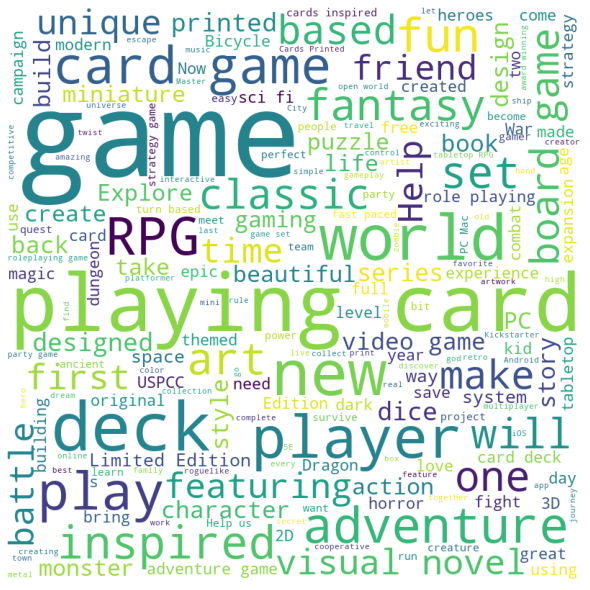

In [38]:
success=' '.join(df_lang.query('state==1').blurb)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(success) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Despite the obvious **game**, important words seem to **playing cards**, **adventure**, **phantasy**, etc.

### 3.3. The quick and dirty way.

To get an overview, what scoring our best model has to beat, we create a quick model. For that we use the Count Vectorizer with english stopwords, and a logistic regression, with the default hyper parameters.

In [39]:
vec = CountVectorizer(stop_words='english')
X_train_vec = vec.fit_transform(X_train)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
X_test_vec = vec.transform(X_test)
y_pred = log_reg.predict(X_test_vec)

In [40]:
print('confusion matrix:' )
print(confusion_matrix(y_test, y_pred))
print('F0.5_Score = ' + str(round(fbeta_score(y_test, y_pred, beta=0.5),3)))
print(classification_report(y_test, y_pred))

confusion matrix:
[[312 223]
 [144 685]]
F0.5_Score = 0.768
              precision    recall  f1-score   support

           0       0.68      0.58      0.63       535
           1       0.75      0.83      0.79       829

    accuracy                           0.73      1364
   macro avg       0.72      0.70      0.71      1364
weighted avg       0.73      0.73      0.73      1364



Looks pretty good for a first draft. But target metric - the precision - could be higher!



### 3.4. Grid Search

Let's try to find a better model via Grid Search:

In [41]:
# Fitting the pipelines for the different models
pipe_log1 = Pipeline(steps = [('vectorizer', CountVectorizer()), ('classifier', LogisticRegression(solver='liblinear'))])
pipe_log2 = Pipeline(steps = [('vectorizer', TfidfVectorizer()), ('classifier', LogisticRegression(solver='liblinear'))])
pipe_nb1 = Pipeline(steps = [('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())])
pipe_nb2 = Pipeline(steps = [('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB())])
pipe_rf = Pipeline(steps = [('vectorizer', CountVectorizer(stop_words='english')), ('classifier',RandomForestClassifier())])

In [42]:
#set the scorer
scorer = make_scorer(fbeta_score, beta=0.5)

In [43]:
# set the grids for the different classifiers
log_grid = {
    'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
    'vectorizer__stop_words' : ['english', None],
    'vectorizer__max_df': [0.5, 1.0],
    'vectorizer__min_df': [0, 5],
    'classifier__C': [0.01, 1, 100]
}

nb_grid = {
    'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
    'vectorizer__stop_words' : ['english', None],
    'vectorizer__max_df': [0.5, 1.0],
    'vectorizer__min_df': [0, 5],
    'classifier__alpha': [0.001, 0.01, 0.1, 1]
}

rf_grid = {
    'vectorizer__ngram_range' : [(1,1), (1,2)],
    'vectorizer__max_df': [0.5, 1.0],
    'vectorizer__min_df': [0, 5],
    'classifier__max_depth': [1, 5, 20, 40],
    'classifier__min_samples_leaf': [1, 5, 20, 40]
}

In [44]:
#start the searches

search_log1 = GridSearchCV(estimator = pipe_log1,
                    param_grid = log_grid,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 7)
search_log2 = GridSearchCV(estimator = pipe_log2,
                    param_grid = log_grid,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 7)
search_nb1 = GridSearchCV(estimator = pipe_nb1,
                    param_grid = nb_grid,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 7)
search_nb2 = GridSearchCV(estimator = pipe_nb2,
                    param_grid = nb_grid,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 7)
search_rf = GridSearchCV(estimator = pipe_rf,
                    param_grid = rf_grid,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 7)


search_log1.fit(X_train, y_train)
search_log2.fit(X_train, y_train)
search_nb1.fit(X_train, y_train)
search_nb2.fit(X_train, y_train)
search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [1, 5, 20, 40],
                         'classifier__min_samples_leaf': [1, 5, 20, 40],
                         'vectorizer__max_df': [0.5, 1.0],
                         'vectorizer__min_df': [0, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=7)

In [45]:
# save the best models

best_log1 = search_log1.best_estimator_
best_log2 = search_log2.best_estimator_
best_nb1 = search_nb1.best_estimator_
best_nb2 = search_nb2.best_estimator_
best_rf = search_rf.best_estimator_

In [46]:
# predict and save statistics
y_log1 = best_log1.predict(X_test)
y_log2 = best_log2.predict(X_test)
y_nb1 = best_nb1.predict(X_test)
y_nb2 = best_nb2.predict(X_test)
y_rf = best_rf.predict(X_test)

pre_log1 = precision_score(y_test, y_log1 )
pre_log2 = precision_score(y_test, y_log2)
pre_nb1 = precision_score(y_test, y_nb1)
pre_nb2 = precision_score(y_test, y_nb2)
pre_rf = precision_score(y_test, y_rf)

fb_log1 = fbeta_score(y_test, y_log1, beta = 0.5)
fb_log2 = fbeta_score(y_test, y_log2, beta = 0.5)
fb_nb1 = fbeta_score(y_test, y_nb1, beta = 0.5)
fb_nb2 = fbeta_score(y_test, y_nb2, beta = 0.5)
fb_rf = fbeta_score(y_test, y_rf, beta = 0.5)

#### 3.5. Results

In [47]:
#print the results:

print(f'Scores for Logistic Regression with CountVectorizer:\n F0.5-Score = {round(fb_log1,3)} \n Precision = {round(pre_log1,3)} \n')
print(f'Scores for Logistic Regression with TFidf:\n F0.5-Score = {round(fb_log2,3)} \n Precision = {round(pre_log2,3)} \n')
print(f'Scores for Naive Bayes with CountVectorizer:\n F0.5-Score = {round(fb_nb1,3)} \n Precision = {round(pre_nb1,3)} \n')
print(f'Scores for Naive Bayes with TFidf:\n F0.5-Score = {round(fb_nb2,3)} \n Precision = {round(pre_nb2,3)} \n')
print(f'Scores for Random Forest with CountVectorizer:\n F0.5-Score = {round(fb_rf,3)} \n Precision = {round(pre_rf,3)} \n')

Scores for Logistic Regression with CountVectorizer:
 F0.5-Score = 0.78 
 Precision = 0.772 

Scores for Logistic Regression with TFidf:
 F0.5-Score = 0.793 
 Precision = 0.793 

Scores for Naive Bayes with CountVectorizer:
 F0.5-Score = 0.81 
 Precision = 0.826 

Scores for Naive Bayes with TFidf:
 F0.5-Score = 0.799 
 Precision = 0.799 

Scores for Random Forest with CountVectorizer:
 F0.5-Score = 0.744 
 Precision = 0.714 



We can see that **Naive Bayes with a Count Vectorizer** has the highest precision and F0.5-score. But ***Logistic Regression with a TFidf Vectorizer*** is in a similar range. Logistic regression has the advantage that we can print the weight of each word for our prediction and thus can see, which words are indicators of success and failure. So we choose that model and print the 10 most important words for success and failure.

In [48]:
eli5.show_weights(best_log2, top=(10, 10))

Weight?,Feature
+10.256,rpg
+9.781,tabletop
+8.497,adventure
+7.783,in this
+7.716,novel
+7.293,visual novel
+7.138,pc
+7.103,explore
+7.085,dice
+6.640,board


#### Word clouds for positive and negative features:

In [49]:
weights = best_log2.named_steps['classifier'].coef_.tolist()[0]
features = best_log2.named_steps['vectorizer'].get_feature_names()
zipped = zip(features, weights)
neg_zip = sorted(zipped, key=lambda x: x[1])[:201]
zipped = zip(features, weights)
pos_zip = sorted(zipped, key=lambda x: x[1], reverse=True)[:201]
pos_feat = {x:y for x,y in pos_zip}
neg_feat = {x:-y for x,y in neg_zip}

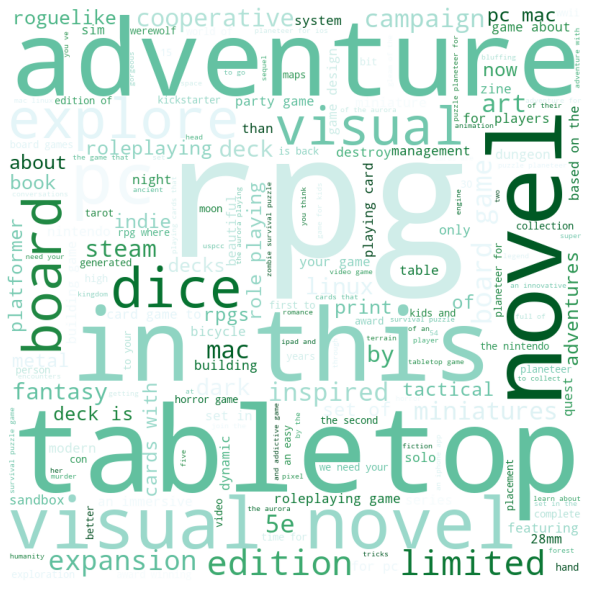

In [50]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(pos_feat) 
wordcloud.recolor(colormap='BuGn')  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

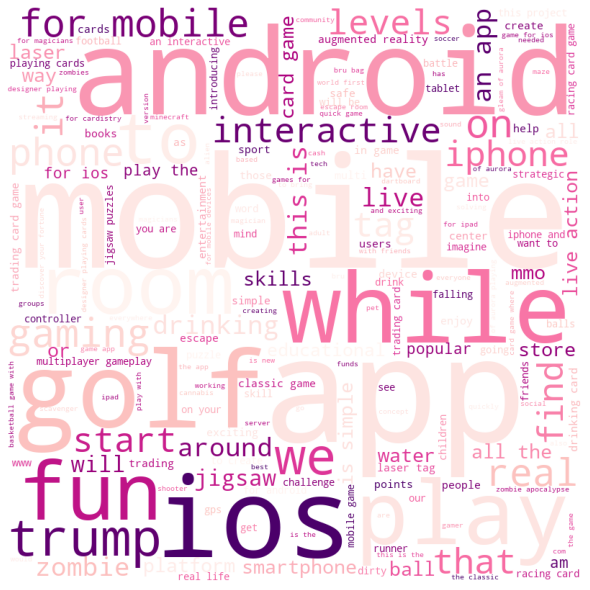

In [51]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(neg_feat) 
wordcloud.recolor(colormap='RdPu')  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [52]:
#save the best model as pickle
joblib.dump(best_log2, 'models/nlp_model.pkl', compress=1)

['models/nlp_model.pkl']

#### 3.7. Conclusion

**Games** are a potentially highly profitable category for our stakeholder. With the analysis and our model, we are able to predict, whether a game campaign will succeed or not, by scanning the description text. The precision of 78.4% is a good value in our eyes. With that we could scan Kickstarter for new gaming campaigns and establish contact to promising campaigns for a possible cooperation.

Furthermore we are able to see, that rpg, tabletop and board games seem to be a profitable branch of gaming, while mobile games are not!

Our conclusion is: **Invest in nerds!**